In [4]:
#Import all necessary library
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import rcParams
import pickle

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

#keras 
import keras
import keras.backend as K
from keras.models import Sequential # a linear stack of neural network layers
from keras.layers import Dense, Dropout, Activation, Flatten # the layers that are used in almost any neural network
from keras.layers import Convolution2D, MaxPooling2D # 2D convolutional and pooling layer
from keras.optimizers import SGD
from keras.utils import np_utils # help us transform our data later
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier

In [5]:
# Define global parameter
seed = 77
np.random.seed(seed)

batch_size = 16
num_classes = 12
num_epochs = 100

# INPUT IMAGE DIMENSIONS
img_row, img_col = 16, 16
channel = 1

In [6]:
# Function to load data
def load_data():
    pkl_file = open('../Data/Image.pkl', 'rb')
    ImageF = pickle.load(pkl_file)
    pkl_file.close()
    

    
    pkl_file = open('../Data/targetdata.pkl', 'rb')
    target = pickle.load(pkl_file)
    pkl_file.close()
    
    
    #unique households
    pkl_file = open('../Data/housedata.pkl', 'rb')
    households = pickle.load(pkl_file)
    pkl_file.close()
    
    #house label
    pkl_file = open('../Data/loc_label.pkl', 'rb')
    loc_label = pickle.load(pkl_file)
    pkl_file.close()
    
    #appliances label
    pkl_file = open('../Data/Appliance_data.pkl', 'rb')
    appliance = pickle.load(pkl_file)
    pkl_file.close()
    
    return ImageF, target, households, loc_label, appliance


In [7]:
# define the cnn_model
def cnn_model():
    model = Sequential() # declare a sequential model
    model.add(Convolution2D(32,    # number of filter layers
                        3,    # y dimension of kernel (we're going for a 3x3 kernel)
                        3,    # x dimension of kernel
                        activation='relu',
                        input_shape=(img_row, img_col, channel)))# Convolutional input layer, 32 feature maps with a size of 3×3 and a rectifier activation function
    model.add(Convolution2D(32, 3, 3,activation='relu')) # Convolutional layer, 32 feature maps with a size of 3×3 and a rectifier activation function.
    model.add(MaxPooling2D(pool_size=(2, 2))) # Max Pool layer with size 2×2.
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))#Fully connected layer with 512 units and a rectifier activation function
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))#Fully connected output layer with 10 units and a softmax activation function.
    
    lrate = 0.01
    decay = lrate/num_epochs
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'], verbose=0)

    return model

In [8]:
# define Random forest model
def rforest_model():
    rForest = RandomForestClassifier(max_depth=10,n_estimators=20)
    return rForest

In [9]:
#define classier model
def classifiers(X_train,y_train,X_test,y_test):
    '''
    This is the classifier function. It takes training and validation data and excute the random forest and CNN model.
    '''
    acc = []
    f_score = []
    recall = []
    prec = []
    y_pred = []
    model_name = ["RandomForest","Convolutional"]
    rForest = rforest_model()
    cnnModel = cnn_model()
    classifiers = [rForest,cnnModel]    
    
    for (i, model) in enumerate(classifiers):
        
        if model == cnnModel:
            train_cnn= np.reshape(X_train, (X_train.shape[0],X_train.shape[1], X_train.shape[2],1))   # Reshape input 
            test_cnn= np.reshape(X_test, (X_test.shape[0], X_test.shape[1],X_test.shape[2], 1))
            model.fit(train_cnn, y_train, batch_size=batch_size, nb_epoch=num_epochs, verbose=0, validation_data=(test_cnn, y_test))
            pred_cnn=np.around(model.predict(test_cnn, batch_size=16, verbose=0))
            acc.append(accuracy_score(y_test, pred_cnn))
            f_score.append(f1_score(y_test, pred_cnn, average='macro'))
            recall.append(recall_score(y_test, pred_cnn, average='macro'))
            prec.append(precision_score(y_test, pred_cnn, average='macro'))
            y_pred.append(pred_cnn) 
        
        else:
            train_forest=np.reshape(X_train,(len(X_train),img_row*img_col))
            test_forest=np.reshape(X_test,(len(X_test),img_row*img_col))
            model.fit(train_forest, y_train)
            pred_forest=np.around(model.predict(test_forest))
            acc.append(accuracy_score(y_test, pred_forest))
            f_score.append(f1_score(y_test, pred_forest, average='macro'))
            recall.append(recall_score(y_test, pred_forest, average='macro'))
            prec.append(precision_score(y_test, pred_forest, average='macro'))
            y_pred.append(pred_forest)
            
    

    return (acc, f_score, recall, prec, y_pred, model_name)
    

In [10]:
# define evaluation function
def evaluate_model():
    data, target, house, label, appliance = load_data() # load data
    target=np_utils.to_categorical(target,)
    F = [data]
    start = datetime.now()
    num_house = len(house) # number of houses
    num_model = 2 # number of model to evaluate
    num_f = len(F) #number of feature
    score_acc = []
    score_prec = []
    score_recall = []
    f_score = []
    acc = np.empty([num_f,num_model])
    predictedY = [[np.empty([0],dtype='int')]*num_model]*num_f
    trueY = np.empty([0],dtype='int')
    name = []
    
    for i in range(num_house):   
        print('%d/%d fold...\t time consumed: %ds'%(i+1,num_house,(datetime.now()-start).seconds))
        # split data into X_train,y_train,X_test,y_test based on households
        test_index = np.where(label==i+1)[0]
        train_index = np.where(label!=i+1)[0]
       
        
        # loop over each feature
        for (j,f) in enumerate(F):
            X_train = data[train_index]
            Y_train = target[train_index]
            X_valid = data[test_index]
            Y_valid = target[test_index]
            
            (acc, f1, recall, prec, y_pred, name) = classifiers(X_train, Y_train, X_valid, Y_valid)
            
            predictedY[j] = [np.hstack([predictedY[j][ii],np.argmax(y_pred[ii])]) for ii in range(num_model)]
    
        trueY = np.hstack([trueY,np.argmax(Y_valid)])
        name.append(name)
    
    return (predictedY, trueY, name)

In [ ]:
# Format python plot with Latex
SPINE_COLOR = 'gray'
from math import sqrt

def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.
    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': ['\\usepackage{gensymb}'],
              'axes.labelsize': 10, # fontsize for x and y labels (was 10)
              'axes.titlesize': 14,
              'text.fontsize': 12, # was 10
              'legend.fontsize': 10, # was 10
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
            
    }

    matplotlib.rcParams.update(params)
    

In [ ]:
# Format axes plot
def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

#    matplotlib.pyplot.tight_layout()

    return ax

In [34]:
# bar plotting function
def bar_plot(data_1, data_2,color, x_label,leg_label, title, plot_name):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    

    ## the data
    N = len(data_1)


    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars

    ## the bars
    rects1 = ax.bar(ind, data_1, width, color=color[0])

    rects2 = ax.bar(ind+width, data_2, width, color=color[1])

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    ax.set_ylim(0,1)
    ax.set_ylabel('Scores\n (Higher is better)')
    ax.set_title(title)
    xTickMarks = (x_label)
    ax.set_xticks(ind+width)
    xtickNames = ax.set_xticklabels(xTickMarks)
    plt.setp(xtickNames, rotation=0)

    ## add a legend
    ax.legend( (rects1[0], rects2[0]), (leg_label[0], leg_label[1]) )
    format_axes(ax)
    
    plt.savefig('../image/%s.pdf' %(plot_name), format='pdf')
    plt.show()

In [11]:
# Run the experiment
y_p,y_t, name = evaluate_model()

1/55 fold...	 time consumed: 0s
2/55 fold...	 time consumed: 80s
3/55 fold...	 time consumed: 162s
4/55 fold...	 time consumed: 245s
5/55 fold...	 time consumed: 328s
6/55 fold...	 time consumed: 416s
7/55 fold...	 time consumed: 503s
8/55 fold...	 time consumed: 596s
9/55 fold...	 time consumed: 684s
10/55 fold...	 time consumed: 776s
11/55 fold...	 time consumed: 877s
12/55 fold...	 time consumed: 974s
13/55 fold...	 time consumed: 1074s
14/55 fold...	 time consumed: 1177s
15/55 fold...	 time consumed: 1285s
16/55 fold...	 time consumed: 1383s
17/55 fold...	 time consumed: 1474s
18/55 fold...	 time consumed: 1571s
19/55 fold...	 time consumed: 1663s
20/55 fold...	 time consumed: 1760s
21/55 fold...	 time consumed: 1852s
22/55 fold...	 time consumed: 1943s
23/55 fold...	 time consumed: 2037s
24/55 fold...	 time consumed: 2130s
25/55 fold...	 time consumed: 2225s
26/55 fold...	 time consumed: 2321s
27/55 fold...	 time consumed: 2415s
28/55 fold...	 time consumed: 2511s
29/55 fold...	 t

In [12]:
# Find Accuracy
Acc = np.array([[accuracy_score(y_t, i) for i in j] for j in y_p])

In [13]:
# Calculate metrics
F1= np.array([[f1_score(y_t, i, average='macro') for i in j] for j in y_p])
Recall = np.array([[recall_score(y_t, i, average='macro') for i in j] for j in y_p])
Prec= np.array([[precision_score(y_t, i, average='macro') for i in j] for j in y_p])

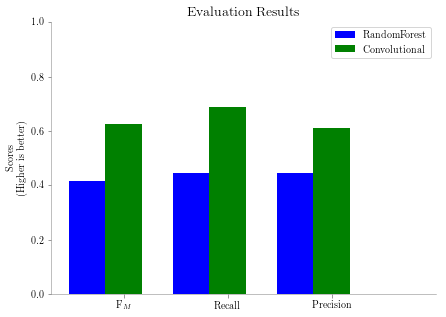

In [18]:
# plot
latexify(columns=2, fig_height=5)
data_1 = [F1[:,0], Recall[:,0], Prec[:,0]]
data_2 = [F1[:,1], Recall[:,1], Prec[:,1]]
color = ['blue','green']
x_label = ['F_M','Recall', 'Precision']
leg_label =[name[0], name[1]]
bar_plot(data_1, data_2,color, x_label,leg_label, title="Evaluation Results", plot_name="Results")